In [1]:
import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [2]:
# ##########HYPERPARAMS#####################
epochs = 100
learning_rate = 1e-3
weight_decay = 0.999
batch_size = 1 #CHANGE THIS VERWRIRUNG
seq_length = 8
log_interval = 10 #Log/show loss per batch
input_size=100
##########################################
##########################################

In [3]:
data = np.load('../YamahaPianoCompetition2002NoTranspose.npz')
#midiDatasetTrain = data['train']
midiDatasetTest = data['test']
data.close()

# Load test set

In [4]:
#midiDatasetTrain = torch.from_numpy(midiDatasetTrain)
#trainLoader = torch.utils.data.DataLoader(midiDatasetTrain, batch_size=batch_size, shuffle=True, drop_last=True)

midiDatasetTest = torch.from_numpy(midiDatasetTest)
testLoader = torch.utils.data.DataLoader(midiDatasetTest, batch_size=batch_size, shuffle=False, drop_last=True)

# Load models

In [5]:
from utils.LSTM_Predicter import LSTM
from utils.VAE_ReLU import VAE
from loadModel import loadModel

#for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load models
lstmModel = LSTM()
autoencoderModel = VAE()

#load weights
lstmModel = loadModel(lstmModel, '../models/LSTM_NEW_YamahaPianoComp2002_100Epochs.model')
autoencoderModel = loadModel(autoencoderModel, 
                             '../models/YamahaPC2002_VAE_Reconstruct_NoTW_10Epochs_ReLU.model',
                            dataParallelModel=False)


--------GPU model restored--------


--------GPU model restored--------



# Generate new sample by feeding 8

torch.Size([8, 100])
torch.Size([1, 100])
torch.Size([1, 1, 96, 60])
(96, 60)
INPUT
(768, 128)


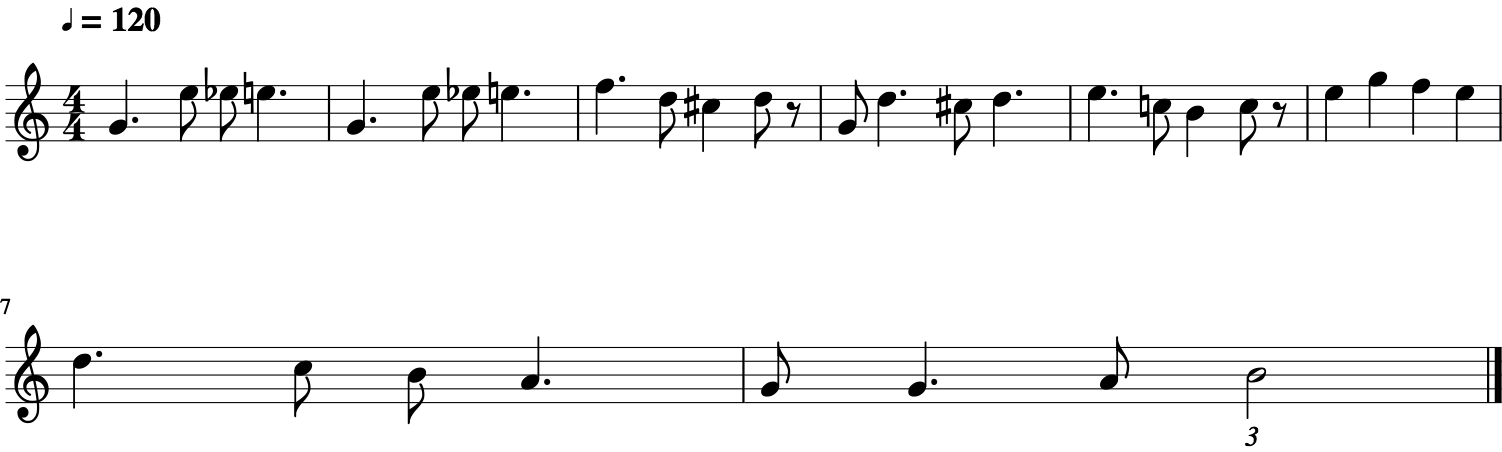

PREDICTION


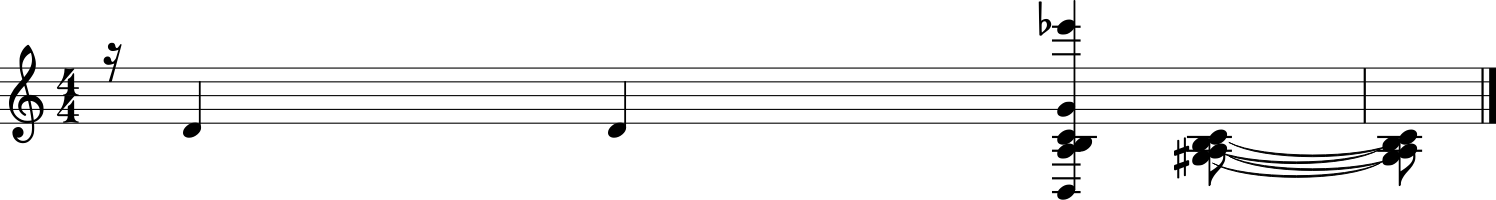




torch.Size([8, 100])
torch.Size([1, 100])
torch.Size([1, 1, 96, 60])
(96, 60)
INPUT
(768, 128)


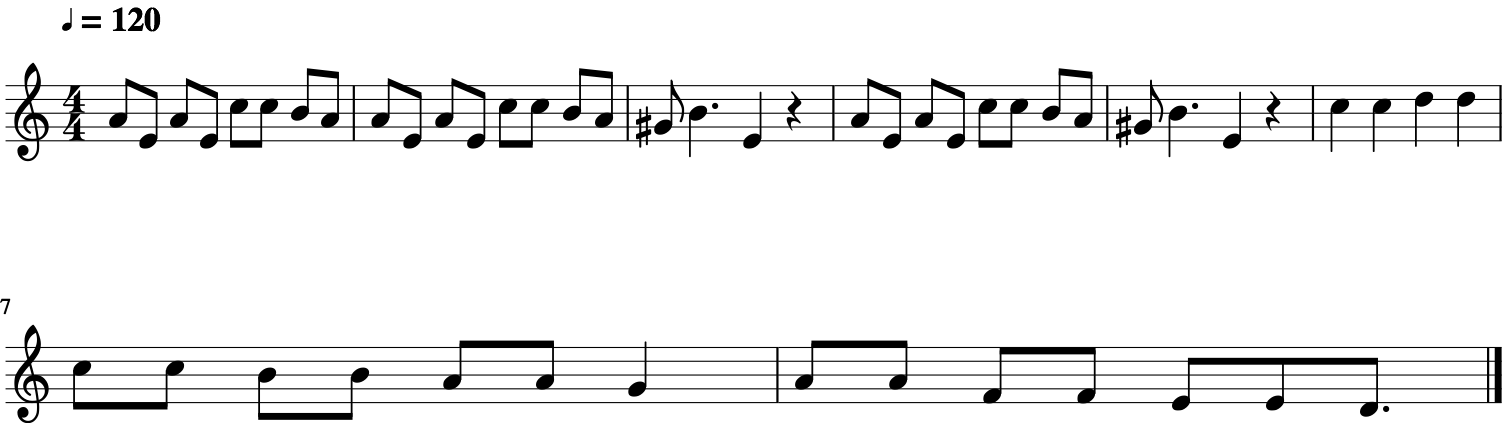

PREDICTION


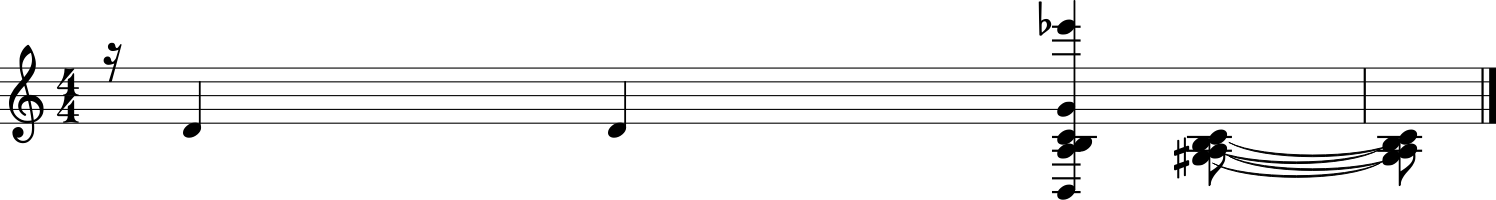

KeyboardInterrupt: 

In [7]:
playSeq = 0
lstmModel.batch_size=1

if(lstmModel.train()):
    lstmModel.eval()
if(autoencoderModel.train()):
    autoencoderModel.eval()

with torch.no_grad():
    for pathToSampleSeq in glob.glob('../WikifoniaDatabase/test/*.mid'):
        sampleNp1 = getSlicedPianorollMatrixNp(pathToSampleSeq)
        sampleNp1 = deleteZeroMatrices(sampleNp1)
        sample = np.expand_dims(sampleNp1[0,:,36:-32],axis=0)
        #print(sample.shape)
        for i, sampleNp in enumerate(sampleNp1[playSeq:playSeq+(seq_length-1)]):
            #print(sampleNp.shape)
            if(np.any(sampleNp)):
                sampleNp = sampleNp[:,36:-32]
                sampleNp = np.expand_dims(sampleNp,axis=0)
                sample = np.concatenate((sample,sampleNp),axis=0)
        samplePlay = sample[0,:,:]
        for s in sample[1:]:
            samplePlay = np.concatenate((samplePlay,s),axis=0)
        samplePlay = addCuttedOctaves(samplePlay)
        #print(samplePlay.shape)
        
        #####PREPARE SAMPLE for input
        sample = torch.from_numpy(sample).float().to(device)
        sample = torch.unsqueeze(sample,1)

        #####MODEL##############
        embed, _ = autoencoderModel.encoder(sample)
        print(embed.size())
        embed = embed.unsqueeze(0).double()
        embed, lstmOut = lstmModel(embed, future=0)
        lstmOut = lstmOut.float()
        print(lstmOut.size())
        #recon = autoencoderModel.decoder(embed.float())
        #print(recon.size())
        pred = autoencoderModel.decoder(lstmOut)
        print(pred.size())
        ########################

        predict = pred.squeeze(0).squeeze(0).cpu().numpy()
        print(predict.shape)
        #print(predict.shape)

        #NORMALIZE PREDICTIONS
        #reconstruction /= np.abs(np.max(reconstruction))
        prediction = predict
        prediction /= np.abs(np.max(prediction))
        #print(prediction)

        #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
        #reconstruction[reconstruction < 0.3] = 0
        prediction[prediction < 0.3] = 0
        #print(prediction)

        samplePlay = debinarizeMidi(samplePlay, prediction=False)
        samplePlay = addCuttedOctaves(samplePlay)
        #reconstruction = debinarizeMidi(reconstruction, prediction=True)
        #reconstruction = addCuttedOctaves(reconstruction)
        prediction = debinarizeMidi(prediction, prediction=True)
        prediction = addCuttedOctaves(prediction)
        print("INPUT")
        print(samplePlay.shape)
        pianorollMatrixToTempMidi(samplePlay, show=True,showPlayer=True,autoplay=False)
        #print("RECONSTRUCTION")
        #pianorollMatrixToTempMidi(reconstruction, show=True,
        #                            showPlayer=True,autoplay=True, prediction=True)
        print("PREDICTION")
        pianorollMatrixToTempMidi(prediction, prediction=True, 
                                  show=True,showPlayer=True,autoplay=True)        
        print("\n\n")
        
        

print('')